# InstaCart Analysis & Reorder prediction

Dataset source: 
https://www.kaggle.com/c/instacart-market-basket-analysis/data

Objective: 
The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data 

In [2]:
orders = pd.read_csv("./instacart-market-basket-analysis/orders.csv")
products = pd.read_csv("./instacart-market-basket-analysis/products.csv")
departments = pd.read_csv("./instacart-market-basket-analysis/departments.csv")
aisles = pd.read_csv("./instacart-market-basket-analysis/aisles.csv")
sample_submission = pd.read_csv("./instacart-market-basket-analysis/sample_submission.csv")
order_products__prior = pd.read_csv("./instacart-market-basket-analysis/order_products__prior.csv")
order_products__train = pd.read_csv("./instacart-market-basket-analysis/order_products__train.csv")

## View data

### Orders 

In [3]:
print(orders.shape)
print(orders.isnull().sum())
# display(orders.describe())
orders.head()

(3421083, 7)
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Products

In [4]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Departments

In [5]:
print(departments.shape)
departments.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Aisles

In [6]:
print(aisles.shape)
aisles.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Prior data of ordered products

In [7]:
print(order_products__prior.shape)
order_products__prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Training data of ordered products

In [8]:
print(order_products__train.shape)
order_products__train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Data manipulation/cleaning
### Combine tables to a master table.

1. Merge products and aisles on product_id
2. Merge products and departments on department_id
3. Concat orders prior and orders train tables to master table
4. Merge new products table from 1 & 2 with master table from 3.

In [9]:
products_new = pd.merge(left=products, right=aisles, on=["aisle_id"]).sort_values(by=['product_id']).reset_index(drop=True)
product = pd.merge(left=products_new, right=departments, on=["department_id"]).sort_values(by=["product_id"]).reset_index(drop=True)


In [10]:
master_df = pd.concat([order_products__prior, order_products__train]).sort_values(by=['order_id'])

master_df = pd.merge(left = master_df, right = product,
                             on='product_id').sort_values(by=['order_id']).reset_index(drop=True)    

master_df = pd.merge(left=master_df, right= orders, on=['order_id']).sort_values(by=['order_id']).reset_index(drop=True)

In [11]:
master_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0
2,1,13176,6,0,Bag of Organic Bananas,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
3,1,47209,7,0,Organic Hass Avocado,24,4,fresh fruits,produce,112108,train,4,4,10,9.0
4,1,22035,8,1,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs,112108,train,4,4,10,9.0


In [12]:
# Show prior/train data based on user_id and order numbers

data = master_df.pivot_table(values='eval_set', index = ['user_id'], columns=['order_number'], aggfunc='first', dropna=True).fillna('')
data.iloc[:, :20].head(5)

order_number,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
user_id,,,,,,,,,,,,,,,,,,,,
1,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,train,,,,,,,,,
2,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,train,,,,,
3,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,prior,,,,,,,,
4,prior,prior,prior,prior,prior,,,,,,,,,,,,,,,
5,prior,prior,prior,prior,train,,,,,,,,,,,,,,,


### Replace NaN values 

In [13]:
print(master_df.isnull().sum())

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
dtype: int64


In [14]:
master_df.loc[master_df['order_number']== 1,'days_since_prior_order'] = 0
print(master_df.isnull().sum())

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64


## Data stats

In [15]:
print ("\nNumber of Rows : ", len(master_df))
print ("Unique user_id: ", master_df['user_id'].nunique())
print ("Unique order_id: ", master_df['order_id'].nunique())
print ("Unique product_id: ", master_df['product_id'].nunique())
print ("Unique aisle_id: ", master_df['aisle_id'].nunique())
print ("Unique department_id: ", master_df['department_id'].nunique())
print ("Unique add_to_cart_order: ", master_df['add_to_cart_order'].nunique())
print ("Unique reordered: ", master_df['reordered'].nunique())
print ("Unique product_name: ", master_df['product_name'].nunique())
print ("Unique aisle: ", master_df['aisle'].nunique())
print ("Unique department: ", master_df['department'].nunique())
print ("Unique eval_set: ", master_df['eval_set'].nunique())
print ("Unique order_number: ", master_df['order_number'].nunique())
print ("Unique order_dow: ", master_df['order_dow'].nunique())
print ("Unique order_hour_of_day: ", master_df['order_hour_of_day'].nunique())
print ("Unique days_since_prior_order: ", master_df['days_since_prior_order'].nunique())


Number of Rows :  33819106
Unique user_id:  206209
Unique order_id:  3346083
Unique product_id:  49685
Unique aisle_id:  134
Unique department_id:  21
Unique add_to_cart_order:  145
Unique reordered:  2
Unique product_name:  49685
Unique aisle:  134
Unique department:  21
Unique eval_set:  2
Unique order_number:  100
Unique order_dow:  7
Unique order_hour_of_day:  24
Unique days_since_prior_order:  31


## EDA

1. How many orders are made by a single user?
2. What is the cart size across orders?
3. What are the most popular ordered products?
4. Which aisles do users order the most from?



In [47]:
master_df.groupby('user_id')['order_number'].max().reset_index(name='number of orders')

,user_id,number of orders
0,1,11
1,2,15
2,3,12
3,4,5
4,5,5
...,...,...
206204,206205,4
206205,206206,67
206206,206207,16
206207,206208,49


### Visualization

Text(0.5, 1.0, 'How many orders are made by a single user?')

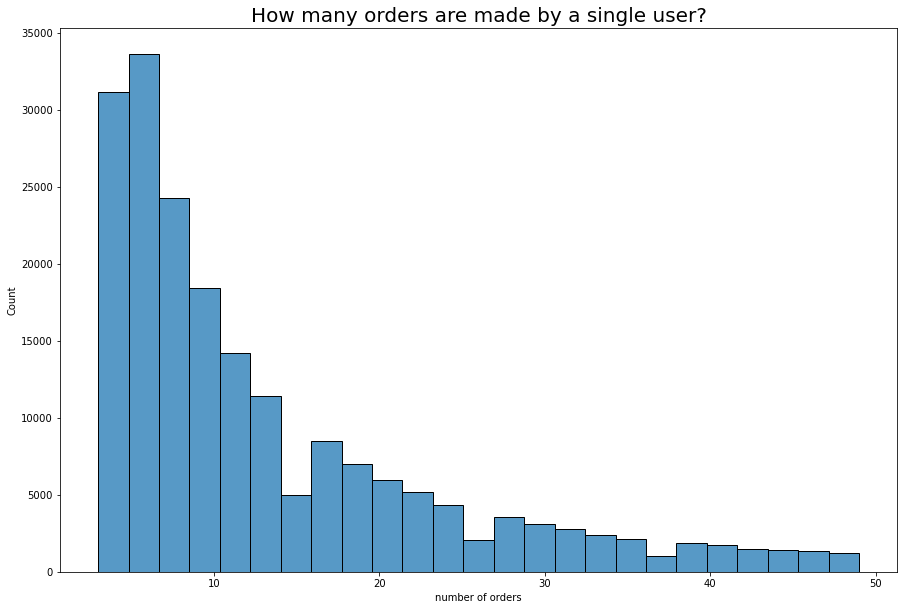

In [58]:
plt.figure(figsize=(15,10))

# Plot 1
data = master_df.groupby('user_id')['order_number'].max().reset_index(name='number of orders')
ax = sns.histplot( data=data[data['number of orders']<50], x = "number of orders", y=None, bins=25)
ax.set_title('How many orders are made by a single user?', fontsize=20)


Text(0.5, 1.0, 'What is the cart size across orders?')

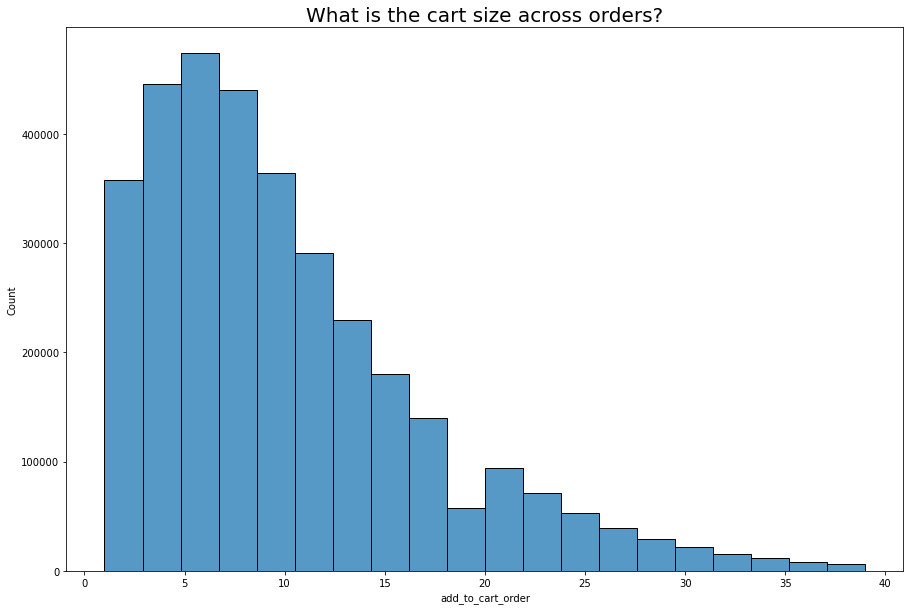

In [17]:
# Plot 2
plt.figure(figsize=(15,10))
data = master_df.groupby('order_id', as_index = False)['add_to_cart_order'].max()
ax = sns.histplot(data[data['add_to_cart_order'] < 40], x = "add_to_cart_order" , bins=20)
ax.set_title('What is the cart size across orders?', fontsize =20)


In [18]:
# master_df.groupby('product_name')['product_id'].size().reset_index(name='number of products').sort_values(by='number of products', ascending=False)

Text(0.5, 1.0, 'What are the most ordered products?')

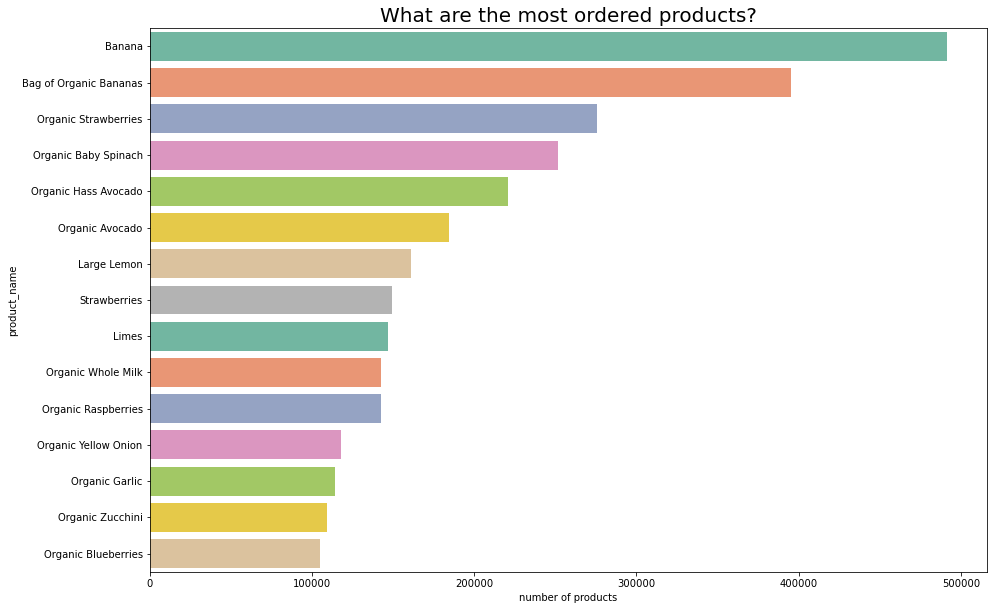

In [19]:
# Plot 3
plt.figure(figsize=(15,10))
data = master_df.groupby('product_name')['product_id'].size().reset_index(name='number of products').sort_values(by='number of products', ascending=False)
ax = sns.barplot(data=data.head(15), y="product_name", x="number of products", palette="Set2")
ax.set_title('What are the most ordered products?', fontsize=20)


Text(0.5, 0, 'count')

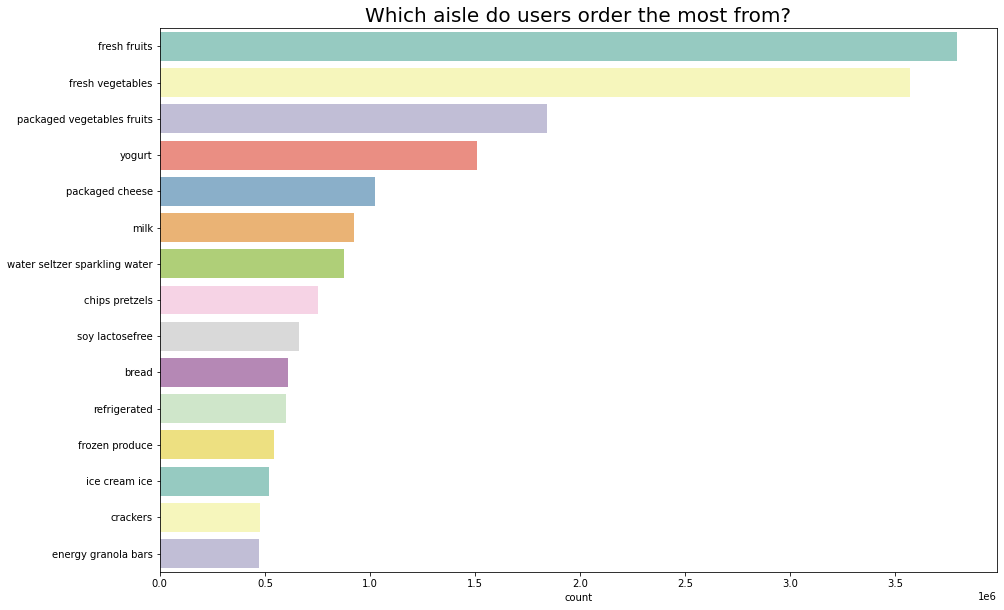

In [20]:
# Plot 4
plt.figure(figsize=(15,10))
data = master_df.groupby('aisle', as_index = False)['aisle_id'].count().sort_values(by='aisle_id', ascending=False)
ax = sns.barplot(data=data.head(15), y="aisle", x="aisle_id", palette="Set3")
ax.set_title('Which aisle do users order the most from?', fontsize=20)
ax.set_ylabel('')
ax.set_xlabel('count')

### Correlation

In [21]:
master_df.corr()

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,1.000000,-0.000101,-0.000235,-0.000187,-0.000095,-0.000106,-0.000499,-0.000462,0.001204,0.000437,0.000615
product_id,-0.000101,1.000000,0.005423,0.003833,0.002083,-0.028449,0.000035,-0.001907,-0.002402,0.000976,0.000537
add_to_cart_order,-0.000235,0.005423,1.000000,-0.133536,0.009517,0.029319,0.000736,-0.003484,-0.009564,-0.014472,0.049738
reordered,-0.000187,0.003833,-0.133536,1.000000,0.003759,-0.039827,-0.001001,0.303610,-0.006952,-0.023051,-0.030025
aisle_id,-0.000095,0.002083,0.009517,0.003759,1.000000,0.062167,-0.000070,-0.000361,-0.002038,-0.001128,0.005399
department_id,-0.000106,-0.028449,0.029319,-0.039827,0.062167,1.000000,0.000029,0.000449,0.004508,-0.008739,0.000743
user_id,-0.000499,0.000035,0.000736,-0.001001,-0.000070,0.000029,1.000000,-0.000882,-0.001849,-0.000445,0.000689
order_number,-0.000462,-0.001907,-0.003484,0.303610,-0.000361,0.000449,-0.000882,1.000000,0.015582,-0.039527,-0.261471
order_dow,0.001204,-0.002402,-0.009564,-0.006952,-0.002038,0.004508,-0.001849,0.015582,1.000000,0.011885,-0.026756
order_hour_of_day,0.000437,0.000976,-0.014472,-0.023051,-0.001128,-0.008739,-0.000445,-0.039527,0.011885,1.000000,0.001097


<AxesSubplot:>

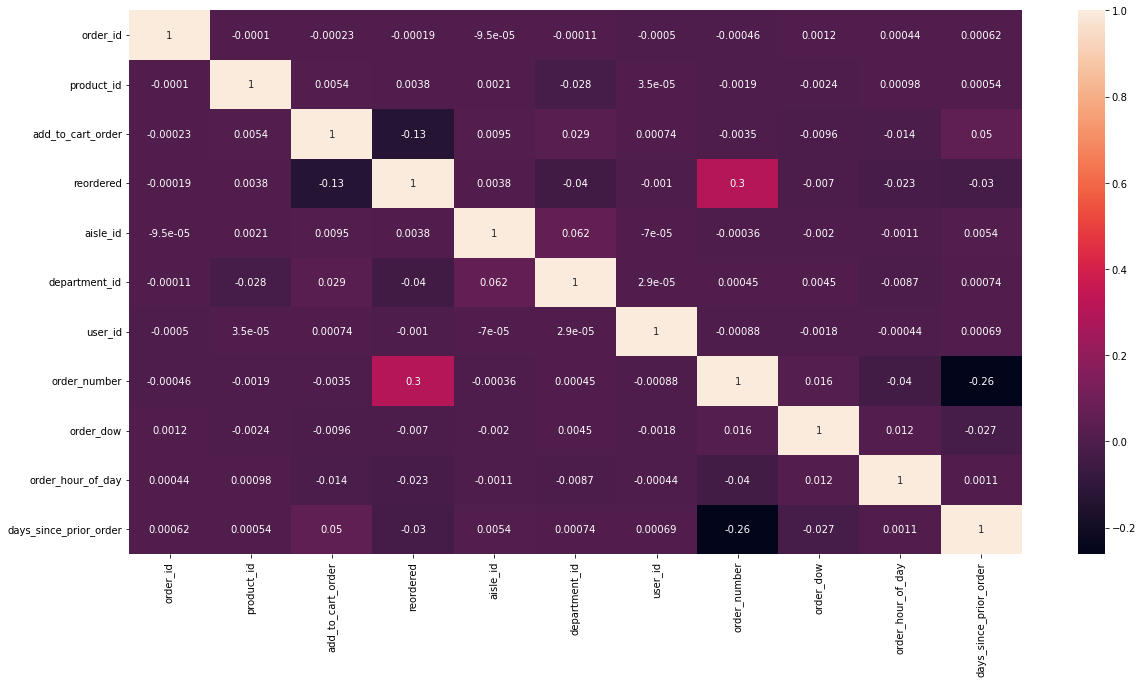

In [22]:
plt.figure(figsize=(20,10))
sns.heatmap(master_df.corr(), annot=True)

In [23]:
master_df.eval_set.value_counts()

prior    32434489
train     1384617
Name: eval_set, dtype: int64

## Feature Engineering 

In [24]:
product_features = pd.DataFrame()

# How many times has this product been ordered? = total orders
product_features['p_total'] = master_df.groupby('product_id')['product_id'].count()

# How many times has this product been reordered? = total reorder
product_features['p_total_reordered'] = master_df.groupby('product_id')['reordered'].sum()

# Mean cart position of each product
product_features['p_mean_cart_pos'] = master_df.groupby('product_id')['add_to_cart_order'].mean()

# Reorder ratio
product_features['p_reorder_ratio']= product_features['p_total_reordered']/product_features['p_total']

product_features

,p_total,p_total_reordered,p_mean_cart_pos,p_reorder_ratio
product_id,,,,
1,1928,1185,5.845954,0.614627
2,94,13,10.138298,0.138298
3,283,209,6.374558,0.738516
4,351,161,9.472934,0.458689
5,16,10,6.375000,0.625000
...,...,...,...,...
49684,9,1,4.333333,0.111111
49685,49,6,9.571429,0.122449
49686,127,89,7.433071,0.700787


In [25]:
users = pd.DataFrame()

# Total number of orders per user
users['u_orders'] = master_df.groupby('user_id')['order_number'].max()

# Mean days since prior order per user
users['u_mean_days_since_prior'] = master_df.groupby(['user_id'])['days_since_prior_order'].mean()

# Mean cart size per user
u_prod_total = master_df.groupby('user_id')['product_id'].count()
users['u_mean_cart_size'] = u_prod_total/users['u_orders']

users

,u_orders,u_mean_days_since_prior,u_mean_cart_size
user_id,,,
1,11,17.828571,6.363636
2,15,16.973451,15.066667
3,12,10.181818,7.333333
4,5,11.944444,3.600000
5,5,9.369565,9.200000
...,...,...,...
206205,4,9.803922,12.750000
206206,67,3.985965,4.253731
206207,16,13.278027,13.937500


In [26]:
# Combine new Users and Products features

u_p_master_df = master_df.merge(right=users, on='user_id')
u_p_master_df = u_p_master_df.merge(right=product_features, on='product_id')

# u_p_master_df.sort_values(by='order_id').head()
u_p_master_df.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered',
       'product_name', 'aisle_id', 'department_id', 'aisle', 'department',
       'user_id', 'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'u_orders', 'u_mean_days_since_prior',
       'u_mean_cart_size', 'p_total', 'p_total_reordered', 'p_mean_cart_pos',
       'p_reorder_ratio'],
      dtype='object')

## Test and Train split

In [27]:
X = u_p_master_df[u_p_master_df.eval_set == 'train']
print(X.shape)

(1384617, 22)


In [28]:
#Correlation after feature engineering and 
# X = X_train[['reordered','days_since_prior_order','u_orders','u_mean_days_since_prior','u_mean_cart_size','p_total','p_total_reordered','p_mean_cart_pos','p_reorder_ratio']]
# plt.figure(figsize=(20,10))
# sns.heatmap(X.corr(), annot=True)

## Modelling


### Logistic Regression

In [29]:
from scipy import stats, special
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection
from sklearn.metrics import classification_report, confusion_matrix


y = X['reordered']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)
lr = linear_model.LogisticRegression(solver='liblinear')

X_train_features = X_train[['days_since_prior_order','u_orders','u_mean_days_since_prior','u_mean_cart_size','p_total','p_total_reordered','p_mean_cart_pos','p_reorder_ratio']]


lr.fit(X_train_features, y_train)
lr.score(X_train_features, y_train)

0.6521288212760794

In [30]:
X_test_features = X_test[['days_since_prior_order','u_orders','u_mean_days_since_prior','u_mean_cart_size','p_total','p_total_reordered','p_mean_cart_pos','p_reorder_ratio']]

y_pred = lr.predict(X_test_features)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 49808  89630]
 [ 31226 175491]]


In [31]:
print('\nAccuracy: ', lr.score(X_test_features, y_test)*100)
print('Precision: ', confusion_matrix[1,1].astype(float)/(confusion_matrix[0,1].astype(float)+confusion_matrix[1,1].astype(float))*100)
print('Recall: ', confusion_matrix[1,1].astype(float)/(confusion_matrix[1,0].astype(float)+confusion_matrix[1,1].astype(float))*100)



Accuracy:  65.08616082390837
Precision:  66.1927949879489
Recall:  84.89432412428586


In [32]:
# master_df['prediction_reordered'] = model.predict(X_train)

### Decision Tree

In [33]:
from sklearn import tree

bt_tree = tree.DecisionTreeClassifier(max_depth=10)
bt_tree.fit(X_train_features, y_train)
bt_tree.score(X_train_features, y_train)


0.6933522844360217

In [34]:
y_pred = bt_tree.predict(X_test_features)
print(metrics.accuracy_score(y_test, y_pred))

0.6897719229824789


In [35]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 73208  66230]
 [ 41157 165560]]


In [36]:
print('\nAccuracy: ', bt_tree.score(X_test_features, y_test)*100)
print('Precision: ', confusion_matrix[1,1].astype(float)/(confusion_matrix[0,1].astype(float)+confusion_matrix[1,1].astype(float))*100)
print('Recall: ', confusion_matrix[1,1].astype(float)/(confusion_matrix[1,0].astype(float)+confusion_matrix[1,1].astype(float))*100)
# print('\n', classification_report(y_test, y_pred))


Accuracy:  68.97719229824789
Precision:  71.42672246429959
Recall:  80.09017158724247


## Conclusion

### Sample submission

In [37]:
X_test['reordered_pred']=bt_tree.predict(X_test_features)

/var/folders/n_/l9fqwyz92311dprrhxw7tzyh0000gn/T/ipykernel_47228/2097007031.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['reordered_pred']=bt_tree.predict(X_test_features)


In [61]:
submission_pred = X_test[X_test['reordered']==1].groupby('order_id')['product_id'].agg(list).reset_index(name='real products')
submission_real = X_test[X_test['reordered_pred']==1].groupby('order_id')['product_id'].agg(list).reset_index(name='predicited products')
submission = pd.merge(left=submission_pred, right=submission_real, on='order_id')

In [62]:
pd.set_option('display.max_colwidth', None)
submission

,order_id,real products,predicited products
0,36,"[34497, 43086, 19660]","[43086, 19660]"
1,98,"[45007, 20520, 18117, 15995, 46720, 41387, 27683, 9373, 47601, 13176, 34065, 34126, 27509]","[45007, 20520, 18117, 15995, 46720, 41387, 27683, 9373, 47601, 13176, 34065, 34126, 27509]"
2,218,"[5578, 1194]",[1194]
3,393,[16797],[16797]
4,631,[21137],"[31717, 21137, 7509, 12545]"
...,...,...,...
75481,3420979,[185],[19029]
75482,3420996,"[14947, 27423]","[14947, 27423, 1891, 29118, 36205]"
75483,3420998,"[11520, 8277]","[11520, 8277, 38383]"
75484,3421056,[21709],[21709]


### Model selection

Precision vs Recall tradeoff:

Since we want to make sure that we reduce the type II error, the higher recall classifier (i.e logistic regression multiple features) is preferred because it has fewer false negatives.

We dont mind precision being less because this would mean that more products were classfied as reorderd than the true predicted products. We can still use this in a recommeneder system without hurting bottom line. However, predicting products falsely as not re-ordered when in fact it was ordered impacts revenue significantly for future predictions.  

### Future goals

How to use this classifier effectively:
1. Increase loyalty and develop habits by marketing high reordered products
2. Maximize profits by increasing frequency of customers - targeting low order/high cart size customers 
3. Group certain products together for easy ordering based on customers


Use other columns to create new features for prediction:
1. Day of the week 
2. Hour of the day
3. Product cart position
